In [ ]:
import h5py
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pde
from pprint import pprint
from IPython.display import Video

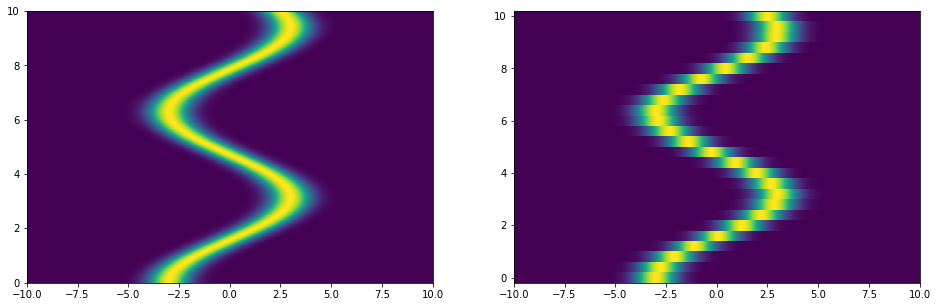

In [ ]:
# Effect of different timesteps:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.pcolormesh(x,t, np.abs(u)**2)
ax2.pcolormesh(x,t[::40], np.abs(u[::40,:])**2)

In [ ]:
n_iter=20

results = {'jump%i' % i : [] for i in range(1,n_iter+1)}

for jump in range(10,n_iter+1):

    print('\n ITERATION:',jump,'\n')

    ## LOAD DATA ## 

    data = h5py.File('./Data/Simulations/Quantum_Osc_w_1_long.h5')

    t = np.array(data['times'][::jump])
    dt = t[1]-t[0]

    x = np.array(data['x'])
    dx = x[1]-x[0]

    u = np.array(data['data'][::jump,:])
    u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)


    data.close()


    ## GET REAL AND IMG PART TO USE WITH SINDY ## 

    training_frac = 1
    train_sample = int(len(t)*training_frac)

    u_real = np.real(u)
    u_img = np.imag(u)

    u_dot_real = np.real(u_dot)
    u_dot_img = np.imag(u_dot)

    u_shaped = np.zeros(shape=(len(x), train_sample, 3))
    u_shaped[:,:, 0]=u_real[:train_sample].T
    u_shaped[:,:, 1]=u_img[:train_sample].T
    u_shaped[:,:, 2]=np.tile(x,(train_sample,1)).T # add x values to pass to u and u_dot (in these way one can introduce spatial potential terms)

    u_dot_shaped = np.zeros(shape=(len(x), train_sample, 2))
    u_dot_shaped[:,:, 0]=u_dot_real[:train_sample].T
    u_dot_shaped[:,:, 1]=u_dot_img[:train_sample].T

    ## DEFINE CANDIDATES LIBRARY ## 
    # 2nd order poly library
    poly_library = ps.PolynomialLibrary(include_bias=False, degree=2) 

    # PDE library
    library_functions = [lambda x: x]
    library_function_names = [lambda x: x]
    pde_library = ps.PDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2, spatial_grid=x, 
                            include_bias=True, is_uniform=True, include_interaction=False)

    # Tensor polynomial library with the PDE library
    tensor_array = [[1, 1]]
    inputs_temp = np.tile([0, 1, 2], 2)
    inputs_per_library = np.reshape(inputs_temp, (2, 3))
    inputs_per_library[1,2] = 0 # only compute PDs for psi_real and psi_img
    inputs_per_library[0] = [2, 2, 2] # only compute polynomial for x input feature


    generalized_library = ps.GeneralizedLibrary(
        [poly_library, pde_library],
        tensor_array=tensor_array,
        inputs_per_library=inputs_per_library,
    )

    ## DEFINE OPTIMIZER AND FIT MODEL ## 

    optimizer = ps.STLSQ(threshold=0.1, verbose=True)
    model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi_r', 'psi_i', 'x'])
    model.fit(u_shaped, x_dot=u_dot_shaped, t=dt)
    #model.print()

    psi_r_rhs=model.equations(precision=16)[0].replace('psi_i_11', 'laplace(psi_i)').replace(' ', '*').replace('*+*', '+').replace('^','**')
    psi_i_rhs=model.equations(precision=16)[1].replace('psi_r_11', 'laplace(psi_r)').replace(' ', '*').replace('*+*', '+').replace('^','**')
    
    cf = model.coefficients()
    results['jump%i' % jump] = [cf[(cf != 0)]]

pprint(results, sort_dicts=False)


 ITERATION: 10 

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.0282e+03 ... 5.9093e-02 ...          6 ... 1.0282e+03
         1 ... 9.8181e+02 ... 6.0724e-02 ...          6 ... 9.8187e+02

 ITERATION: 11 

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.3379e+03 ... 6.6587e-02 ...          6 ... 1.3380e+03
         1 ... 1.2800e+03 ... 6.9143e-02 ...          6 ... 1.2801e+03

 ITERATION: 12 

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.6939e+03 ... 7.6654e-02 ...          6 ... 1.6940e+03
         1 ... 1.6224e+03 ... 8.0418e-02 ...          6 ... 1.6225e+03

 ITERATION: 13 

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 2.0933e+03 ... 8.9627e-02 ...          6 ... 2.0934e+03
         1 ... 2.0063e+03 ... 9.4913e-02 ...   

In [ ]:
M_res = np.zeros((n_iter,6))

for j,key in enumerate(results):
    
    if (len(results[key])==0): pass
    elif(len(results[key][0])==4):
        r = results[key][0]
        M_res[j]=np.array([0,r[0],r[1],0,r[2],r[3]])
    else: 
        r = results[key][0]
        M_res[j] = np.array(r)

print(M_res)

[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.5125416  -0.41683704  0.41686291 -0.5089924   0.4167635  -0.41841192]
 [ 0.61285812 -0.40033994  0.40036181 -0.60856646  0.40022005 -0.40235176]
 [ 0.72001014 -0.38263526  0.38266603 -0.7148904   0.38247276 -0.38511549]
 [ 0.83333615 -0.36381597  0.36385225 -0.8272865   0.3636105  -0.36680519]
 [ 0.95232477 -0.3439669 

Text(0.5, 1.0, '$x^2\\psi_r$ and $-x^2\\psi_i$')

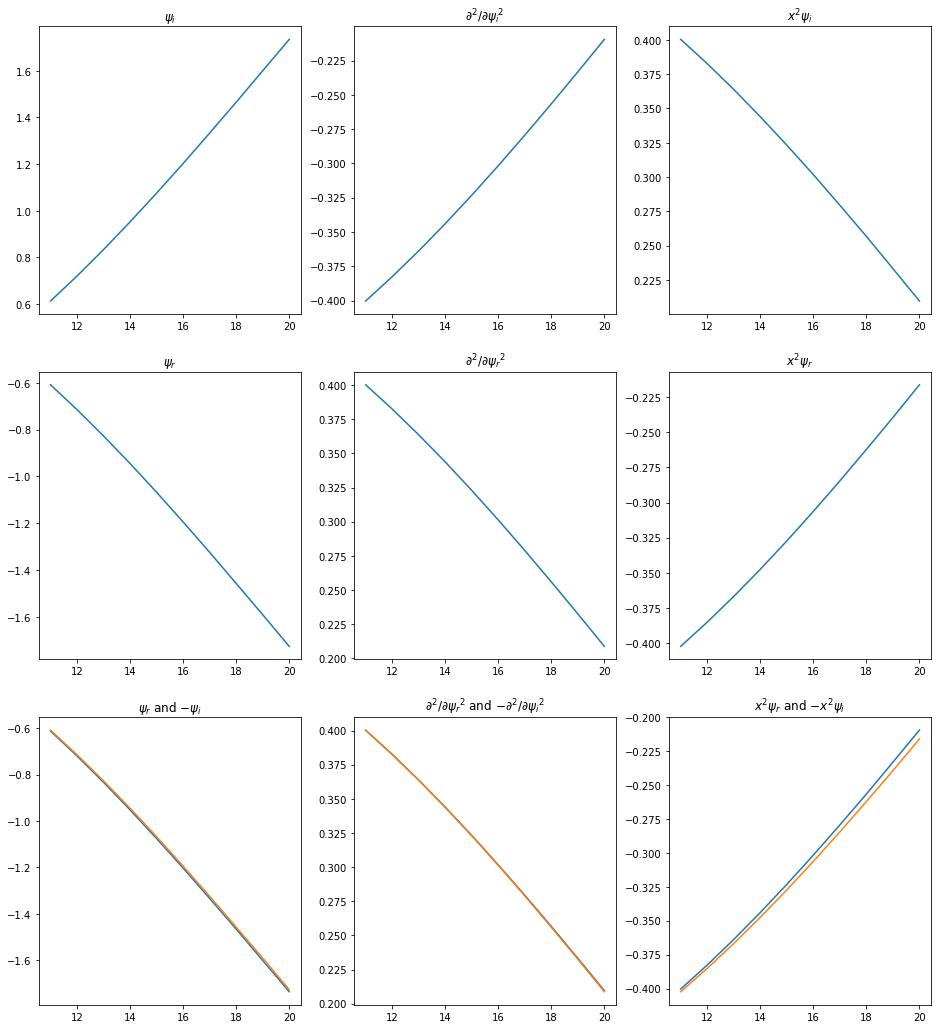

In [ ]:
fig, ((ax1,ax2, ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3,3, figsize=(16,18))
ax1.plot(range(11,n_iter+1),M_res[10:,0])
ax1.set_title('$\psi_i$')
ax2.plot(range(11,n_iter+1),M_res[10:,1])
ax2.set_title('${\partial^2}/{\partial{\psi_i}^2}$')
ax3.plot(range(11,n_iter+1),M_res[10:,2])
ax3.set_title('$x^2\psi_i$')
ax4.plot(range(11,n_iter+1),M_res[10:,3])
ax4.set_title('$\psi_r$')
ax5.plot(range(11,n_iter+1),M_res[10:,4])
ax5.set_title('${\partial^2}/{\partial{\psi_r}^2}$')
ax6.plot(range(11,n_iter+1),M_res[10:,5])
ax6.set_title('$x^2\psi_r$')
# Real sv Imaginary
ax7.plot(range(11,n_iter+1),-M_res[10:,0])
ax7.plot(range(11,n_iter+1),M_res[10:,3])
ax7.set_title('$\psi_r$ and $-\psi_i$')
ax8.plot(range(11,n_iter+1),-M_res[10:,1])
ax8.plot(range(11,n_iter+1),M_res[10:,4])
ax8.set_title('${\partial^2}/{\partial{\psi_r}^2}$ and $-{\partial^2}/{\partial{\psi_i}^2}$')
ax9.plot(range(11,n_iter+1),-M_res[10:,2])
ax9.plot(range(11,n_iter+1),M_res[10:,5])
ax9.set_title('$x^2\psi_r$ and $-x^2\psi_i$')


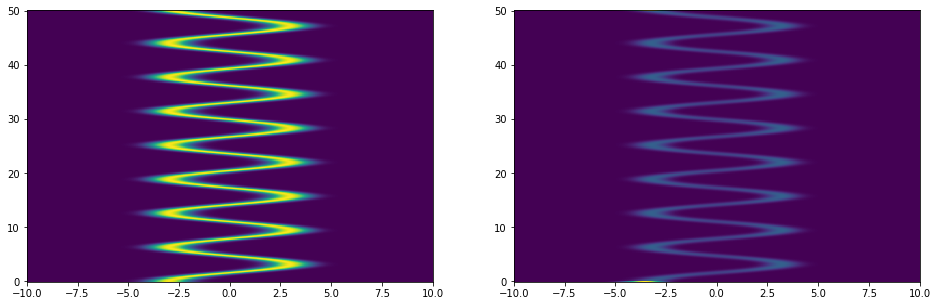

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.pcolormesh(x,t, np.abs(u)**2)
ax2.pcolormesh(x,t, np.abs(u_dot)**2)

In [ ]:
print(t.shape, x.shape, u.shape)

(251,) (1000,) (251, 1000)


## Fit reconstruction and simulation

In [ ]:
len(t)-train_sample

0

In [ ]:
## FITTED MODEL SIMULATION ## 

fig, AX = plt.subplots(3,4,figsize=(15,15))

# TO DO: GENERALIZE EQUATION WRITING FROM MODEL RESULT
for step in range(10,20):

    eq=pde.PDE({'psi_r':psi_r_rhs, 
           'psi_i':psi_i_rhs})

    ## DEFINE SPATIAL GRID ##

    Nx = len(x) # number of spatial points
    x_left = x[0]
    x_right = x[-1]

    grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)
    grid.coordinate_arrays = (x,) # this is needed otherwise endpoints are excluded

    ## DEFINE INITIAL STATE FOR SIMULATION (use last u entry) ##

    initial_state_r = pde.ScalarField(grid, u_real[0], label= '$psi_r$')
    initial_state_i = pde.ScalarField(grid, u_img[0], label = '$psi_i$')

    initial_state = pde.FieldCollection([initial_state_r, initial_state_i])

    ## PERFORM SIMULATION ##

    # define storage 
    storage = pde.MemoryStorage() # for movie

    # simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
    t_range = t[-1]-t[len(t)-train_sample]
    dt_sim = 1e-5

    # points to use in animation 
    N_t_anim = 500 # this is enough do not change it 
    dt_anim = t_range/N_t_anim


    solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
    controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_anim)])
    _ = controller.run(initial_state, dt=dt_sim)
    
    data_sim = np.array([storage.data[i][0]+1j*storage.data[i][1] for i in range(len(storage))])
    storage_sim = pde.MemoryStorage(times=t[0]+np.array(storage.times), data=data_sim, field_obj=pde.ScalarField(grid, label='$psi_sim$', dtype=np.complex128))

    index_row = int((step-10)//3)
    index_col = int((step-10) % 4)
    AX[index_row,index_col].pcolormesh(storage_sim.grid.cell_coords.flatten(), storage_sim.times, abs(storage_sim.data)**2)

plt.show()



0it [04:00, ?it/s]
100%|██████████| 50.00000000000598/50.00000000000598 [28:12<00:00, 33.84s/it]
100%|██████████| 50.00000000000598/50.00000000000598 [10:49<00:00, 12.99s/it]
100%|██████████| 50.00000000000598/50.00000000000598 [11:00<00:00, 13.21s/it]
100%|██████████| 50.00000000000598/50.00000000000598 [10:11<00:00, 12.23s/it]
100%|██████████| 50.00000000000598/50.00000000000598 [10:43<00:00, 12.86s/it]
 43%|████▎     | 21.2905/50.00000000000598 [05:08<06:55, 14.48s/it] 

KernelInterrupted: Execution interrupted by the Jupyter kernel.

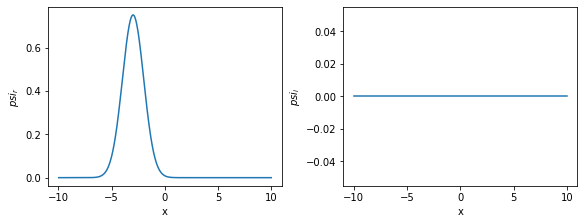

In [ ]:
## FITTED MODEL SIMULATION ## 

# TO DO: GENERALIZE EQUATION WRITING FROM MODEL RESULT

uxx_re = model.coefficients()[0,8]
uxx_im = model.coefficients()[1,7]
x2psi_re = model.coefficients()[0,18]
x2psi_im = model.coefficients()[1,17]
const_re = model.coefficients()[0,4]
const_im = model.coefficients()[1,3]


eq = pde.PDE({'psi_r':'{}*laplace(psi_i)+({}*x*x + {})*psi_i'.format(uxx_re, x2psi_re, const_re ), 
              'psi_i':'{}*laplace(psi_r)+({}*x*x + {})*psi_r'.format(uxx_im, x2psi_im, const_im)})

## DEFINE SPATIAL GRID ##

Nx = len(x) # number of spatial points
x_left = x[0]
x_right = x[-1]

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)
grid.coordinate_arrays = (x,) # this is needed otherwise endpoints are excluded

## DEFINE INITIAL STATE FOR SIMULATION (use last u entry) ##

initial_state_r = pde.ScalarField(grid, u_real[0], label= '$psi_r$')
initial_state_i = pde.ScalarField(grid, u_img[0], label = '$psi_i$')

initial_state = pde.FieldCollection([initial_state_r, initial_state_i])

initial_state.plot()


In [ ]:
## PERFORM SIMULATION ##

# define storage 
storage = pde.MemoryStorage() # for movie

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = 10
dt_sim = 1e-5

# points to use in animation 
N_t_anim = 500 # this is enough do not change it 
dt_anim = t_range/N_t_anim


solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_anim)])
_ = controller.run(initial_state, dt=dt_sim)

100%|██████████| 10.0/10.0 [02:10<00:00, 13.07s/it]


In [ ]:
## COMBINE REAL AND IMAGINARY PART ## 

data_sim = np.array([storage.data[i][0]+1j*storage.data[i][1] for i in range(len(storage))])
storage_sim = pde.MemoryStorage(times=t[0] + np.array(storage.times), data=data_sim, field_obj=pde.ScalarField(grid, label='$psi_sim$', dtype=np.complex128))


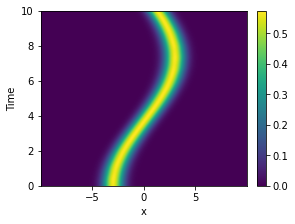

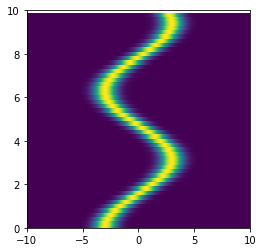

In [ ]:
## PLOT SIMULATION ##

pde.plot_kymographs(storage_sim, scalar='norm_squared')

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.pcolormesh(x, t[:int(t.shape[0]/5)], np.abs(u[:int(u.shape[0]/5),:])**2)
plt.xlim(-10,10)
plt.ylim(0,10.00001)
plt.show()

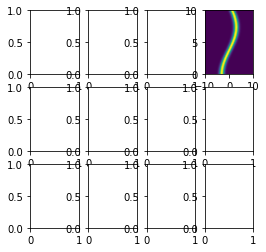

In [ ]:
#storage_sim.grid.cell_coords.flatten()
#storage_sim.times
#storage_sim.data
fig, AX = plt.subplots(3,4,figsize=(4,4))
AX[0,3].pcolormesh(storage_sim.grid.cell_coords.flatten(), storage_sim.times, abs(storage_sim.data)**2)

100%|██████████| 501/501 [00:38<00:00, 13.00it/s]


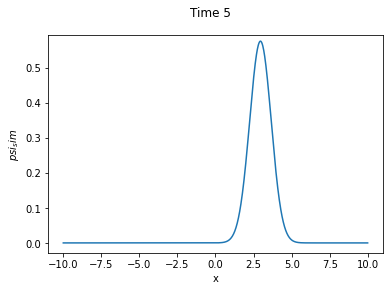

In [ ]:
## CREATE MOVIE ## 

pde.movie(storage_sim, 'broken_timestep_15.mp4', plot_args={'scalar':'norm_squared'}) # TODO: ADD LABELS 

In [ ]:
## VISUALIZE MOVIE ## Does not work in Deepnote...

Video('broken_timestep_15.mp4')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=964d390d-0269-41ab-86ee-4ee3752d1778' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>